In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import scipy
from scipy.stats import poisson, binom, beta
from scipy.optimize import minimize
from scipy.optimize import minimize, NonlinearConstraint

### 1st step - Possession

$$
P^h \sim Normal(0.5 + K^h, \sigma^2)
$$

$$
K^h = \Gamma^h + \Gamma^{HA} - \Gamma^a
$$



In [2]:
data = pd.read_csv('3_step_data.csv', sep=',')

In [3]:
data

,home,away,home_goal,away_goal,home_shots,away_shots,home_possession,away_possession
0,Manchester United,Leicester City,2,1,8,8,0.46,0.54
1,Newcastle United,Tottenham Hotspur,1,2,11,13,0.40,0.60
2,AFC Bournemouth,Cardiff City,2,0,11,7,0.62,0.38
3,Fulham,Crystal Palace,0,2,11,11,0.66,0.34
4,Huddersfield Town,Chelsea,0,3,6,8,0.37,0.63
...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,11,7,0.59,0.41
376,Manchester United,Cardiff City,0,2,21,11,0.73,0.27
377,Southampton,Huddersfield Town,1,1,7,8,0.53,0.47
378,Tottenham Hotspur,Everton,2,2,9,13,0.55,0.45


In [4]:
teams = pd.unique(data[['home', 'away']].values.ravel('K'))
teams_params = pd.DataFrame({
    'Team': teams,
    'gamma': 1,
    'alpha': 10,
    'beta': 3,
    'delta':0.8,
    'zeta': 0.2
})

teams_params.set_index('Team', inplace=True)

In [5]:
hyper_params = {
    'gamma_ha': 0.5,
    'sigma': 0.1,
    'alpha_ha':1
}

In [6]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1,10,3,0.8,0.2
Newcastle United,1,10,3,0.8,0.2
AFC Bournemouth,1,10,3,0.8,0.2
Fulham,1,10,3,0.8,0.2
Huddersfield Town,1,10,3,0.8,0.2
Watford,1,10,3,0.8,0.2
Wolverhampton Wanderers,1,10,3,0.8,0.2
Liverpool,1,10,3,0.8,0.2
Southampton,1,10,3,0.8,0.2


In [7]:
hyper_params

{'gamma_ha': 0.5, 'sigma': 0.1, 'alpha_ha': 1}

In [8]:
n_train = 150
n_validation = 200

data_train = data[:n_train]
data_validation = data[n_train:n_validation]
data_test = data[n_validation:]


In [9]:
def poss_log_likelihood(params, data, team=None):

    gamma_ha = params[-2]
    sigma = params[-1]
    params = params[:-2]


    teams_params = pd.DataFrame({
        'Team': team,
        'gamma': params}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']

        
        gamma_h = teams_params.at[name_h, 'gamma']
        gamma_a = teams_params.at[name_a, 'gamma']
        
        kh = gamma_h + gamma_ha - gamma_a
        

        row_sum = scipy.stats.norm.logpdf(home_poss, 0.5 + kh, sigma**2)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [10]:
# Initial guess
initial_params = teams_params.gamma.values.T.flatten().tolist() + [hyper_params['gamma_ha'], hyper_params['sigma']]  # Flatten alpha and beta, and add initial gamma

In [11]:
poss_log_likelihood(initial_params, data_train, teams_params.index.tolist())

190749.0652520826

In [12]:
# Bounds for
gamma1, gamma2 = 0.0, 0.8
gammaha1, gammaha2 = 0.0, 0.1
sigma1, sigma2 = 0.01, 0.3
bounds = [(gamma1, gamma2)] * len(teams) + [(gammaha1, gammaha2)] + [(sigma1, sigma2)]


# Optimize
result = minimize(poss_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, options={'maxiter': 100}) #, constraints=constraints)

In [13]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -185.43489012825424
        x: [ 6.802e-01  5.388e-01 ...  1.359e-02  2.651e-01]
      nit: 24
      jac: [ 6.679e-04  8.754e-04 ...  4.066e-02 -4.951e-03]
     nfev: 644
     njev: 28
 hess_inv: <22x22 LbfgsInvHessProduct with dtype=float64>

In [14]:
optimized_params = result.x
optimized_gamma_ha = optimized_params[-2]
optimized_sigma = optimized_params[-1]
optimized_gammas = optimized_params[:len(teams)]

In [15]:
hyper_params['gamma_ha'] = optimized_gamma_ha
hyper_params['sigma'] = optimized_sigma
teams_params.gamma = optimized_gammas

In [16]:
hyper_params

{'gamma_ha': np.float64(0.01358502995652996),
 'sigma': np.float64(0.26511630054012336),
 'alpha_ha': 1}

In [17]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,0.680165,10,3,0.8,0.2
Newcastle United,0.538849,10,3,0.8,0.2
AFC Bournemouth,0.604189,10,3,0.8,0.2
Fulham,0.635285,10,3,0.8,0.2
Huddersfield Town,0.619014,10,3,0.8,0.2
Watford,0.595237,10,3,0.8,0.2
Wolverhampton Wanderers,0.595171,10,3,0.8,0.2
Liverpool,0.733990,10,3,0.8,0.2
Southampton,0.602441,10,3,0.8,0.2


In [18]:
def shot_log_likelihood(params, data, team=None):

    alpha_ha = params[-1]
    params = params[:-1]


    teams_params = pd.DataFrame({
        'Team': team,
        'alpha': params[:len(team)],
        'beta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']
        home_shots = row['home_shots']
        away_shots = row['away_shots']

        
        alpha_h = teams_params.at[name_h, 'alpha']
        beta_h = teams_params.at[name_h, 'beta']

        alpha_a = teams_params.at[name_a, 'alpha']
        beta_a = teams_params.at[name_a, 'beta']
        
        lambda_h = alpha_ha + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        row_sum = poisson.logpmf(home_shots, lambda_h*home_poss) + poisson.logpmf(away_shots, lambda_a*away_poss) 
        total_sum += row_sum
    
    return -total_sum.tolist()

In [19]:
# Initial guess
initial_params = teams_params[['alpha', 'beta']].values.T.flatten().tolist() + [hyper_params['alpha_ha']]  # Flatten alpha and beta, and add initial gamma

In [20]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,0.680165,10,3,0.8,0.2
Newcastle United,0.538849,10,3,0.8,0.2
AFC Bournemouth,0.604189,10,3,0.8,0.2
Fulham,0.635285,10,3,0.8,0.2
Huddersfield Town,0.619014,10,3,0.8,0.2
Watford,0.595237,10,3,0.8,0.2
Wolverhampton Wanderers,0.595171,10,3,0.8,0.2
Liverpool,0.733990,10,3,0.8,0.2
Southampton,0.602441,10,3,0.8,0.2


In [21]:
shot_log_likelihood(initial_params, data_train, teams_params.index.tolist())

1996.6103014222062

In [22]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params)-1)/2)
    a = params[:n]
    b = params[n:2*n]
    c = params[-1]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [23]:
# Bounds for alpha, beta, and home adv alpha
a1, a2 = 0, 30.0  # Bounds for alpha
b1, b2 = 0.0, 10.0  # Bounds for beta
c1, c2 = 0.0, 10.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]



# Optimize
result = minimize(shot_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [24]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 738.1505297223844
       x: [ 2.371e+01  2.708e+01 ...  8.722e+00  2.753e+00]
     nit: 26
     jac: [ 8.392e-05 -1.144e-04 ... -3.815e-05  8.621e-04]
    nfev: 1093
    njev: 26

In [25]:
optimized_params = result.x
optimized_alpha_ha = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

In [26]:
hyper_params['alpha_ha'] = optimized_alpha_ha
teams_params.alpha = optimized_alphas
teams_params.beta = optimized_betas

In [27]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,0.680165,23.712108,3.876058,0.8,0.2
Newcastle United,0.538849,27.076319,7.035955,0.8,0.2
AFC Bournemouth,0.604189,25.023999,5.525066,0.8,0.2
Fulham,0.635285,25.845727,1.421693,0.8,0.2
Huddersfield Town,0.619014,24.347253,7.442669,0.8,0.2
Watford,0.595237,24.761419,9.277963,0.8,0.2
Wolverhampton Wanderers,0.595171,30.000000,8.966972,0.8,0.2
Liverpool,0.733990,24.732092,9.055194,0.8,0.2
Southampton,0.602441,29.766929,7.106571,0.8,0.2


In [28]:
hyper_params

{'gamma_ha': np.float64(0.01358502995652996),
 'sigma': np.float64(0.26511630054012336),
 'alpha_ha': np.float64(2.7527440287281153)}

In [29]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = binom.logpmf(home_goal, home_shots, pg_h) + binom.logpmf(away_goal, away_shots, pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [110]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = poisson.logpmf(home_goal, home_shots*pg_h) + poisson.logpmf(away_goal, away_shots*pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [30]:
# Initial guess
initial_params = teams_params[['delta', 'zeta']].values.T.flatten().tolist()  # Flatten alpha and beta, and add initial gamma

In [31]:
goal_log_likelihood(initial_params, data_train, teams_params.index.tolist())

1908.8278716924415

In [32]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params))/2)
    a = params[:n]
    b = params[n:2*n]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [39]:
# Bounds for delta, zeta
a1, a2 = 0, 3.0 
b1, b2 = 0.0, 2.0
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams)



# Optimize
result = minimize(goal_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [40]:
result

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 393.0383179229251
       x: [ 8.418e-01  7.723e-01 ...  6.890e-01  6.783e-01]
     nit: 1
     jac: [ 1.483e-01 -1.447e+00 ... -5.704e-01  3.291e+00]
    nfev: 41
    njev: 1

In [41]:
optimized_params = result.x
optimized_delta = optimized_params[:len(teams)]
optimized_zeta = optimized_params[len(teams):2*len(teams)]

In [42]:
teams_params.delta = optimized_delta
teams_params.zeta = optimized_zeta

In [43]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,0.680165,23.712108,3.876058,0.841846,0.660935
Newcastle United,0.538849,27.076319,7.035955,0.772291,0.722225
AFC Bournemouth,0.604189,25.023999,5.525066,0.850011,0.678717
Fulham,0.635285,25.845727,1.421693,0.770768,0.635709
Huddersfield Town,0.619014,24.347253,7.442669,0.756448,0.655685
Watford,0.595237,24.761419,9.277963,0.805090,0.670465
Wolverhampton Wanderers,0.595171,30.000000,8.966972,0.772152,0.685310
Liverpool,0.733990,24.732092,9.055194,0.838144,0.754399
Southampton,0.602441,29.766929,7.106571,0.754399,0.640124


In [38]:
hyper_params

{'gamma_ha': np.float64(0.01358502995652996),
 'sigma': np.float64(0.26511630054012336),
 'alpha_ha': np.float64(2.7527440287281153)}

In [44]:
def param_calculator(team_h, team_a, params, hyper_params):

    gamma_h, alpha_h, beta_h, delta_h, zeta_h = params.loc[team_h]
    gamma_a, alpha_a, beta_a, delta_a, zeta_a = params.loc[team_a]

    ## Possession
    gamma_ha = hyper_params['gamma_ha']
    sigma = hyper_params['sigma']
    alpha_ha = hyper_params['alpha_ha']

    kh = gamma_h + gamma_ha - gamma_a
    ka = gamma_a - gamma_h


    ## Shots
    lambda_h = alpha_ha + alpha_h - beta_a
    lambda_a = alpha_a - beta_h


    ## Goals
    pg_h = delta_h - zeta_a
    pg_a = delta_a - zeta_h



    return [kh, sigma, lambda_h, pg_h], [ka, sigma, lambda_a, pg_a]


In [45]:
import numpy as np
import scipy.stats as stats
from scipy.integrate import quad

def log_factorial(n):
    """ Compute the logarithm of the factorial of n. """
    return np.sum(np.log(np.arange(1, n + 1)))

def P_C(c, k, sigma, lambd, p):
    """
    Compute the probability P(C = c) for given parameters.
    
    Parameters:
    c (int): The value of C.
    k (float): The parameter k in the normal distribution of A.
    sigma (float): The standard deviation of the normal distribution of A.
    lambd (float): The rate parameter for the Poisson distribution of B given A.
    p (float): The probability parameter for the Binomial distribution of C given B.
    
    Returns:
    float: The probability P(C = c).
    """
    mean_a = 0.5 + k
    std_a = sigma
    lower_limit = max(mean_a - 5 * std_a, 0)
    upper_limit = mean_a + 5 * std_a
    
    # Define the integrand for the marginalization over A
    def integrand(a):
        if a <= 0:
            return 0
        # Normal distribution P(A)
        P_A = stats.norm.pdf(a, loc=mean_a, scale=std_a)
        # Binomial-Poisson mixture P(C | A)
        log_P_C_given_A = c * np.log(p) + c * np.log(lambd * a) - lambd * a * p - log_factorial(c)
        P_C_given_A = np.exp(log_P_C_given_A)
        return P_C_given_A * P_A
    
    # Perform the integration over A
    result, _ = quad(integrand, lower_limit, upper_limit)
    return result



In [46]:
ph, pa = param_calculator('Arsenal', 'Newcastle United', teams_params, hyper_params)

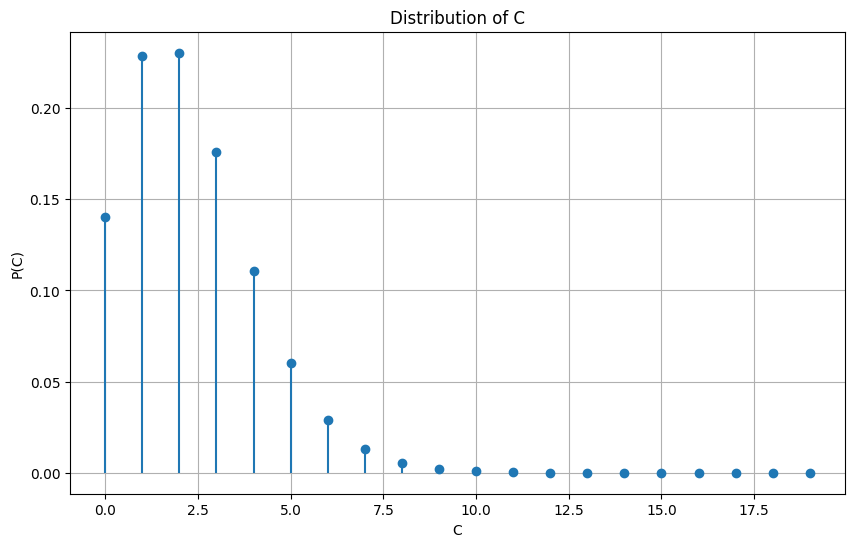

In [47]:
# Compute probabilities for a range of C values
C_values = np.arange(0, 20)
P_C_values = [P_C(c, *ph) for c in C_values]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(C_values, P_C_values, basefmt=" ")
plt.xlabel('C')
plt.ylabel('P(C)')
plt.title('Distribution of C')
plt.grid(True)
plt.show()

In [53]:
ph, pa = param_calculator('Fulham', 'Crystal Palace', teams_params, hyper_params)

In [54]:
#AFC Bournemouth	Cardiff City


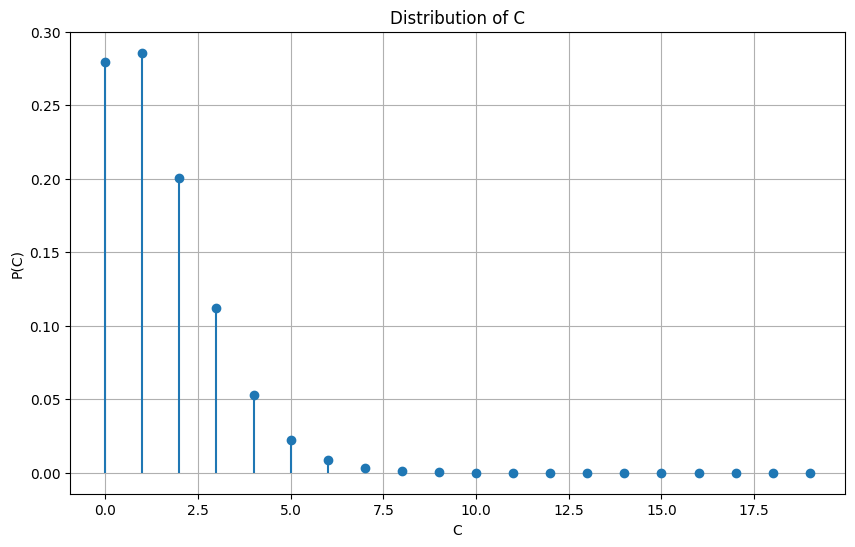

In [55]:
# Compute probabilities for a range of C values
C_values = np.arange(0, 20)
P_C_values = [P_C(c, *pa) for c in C_values]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(C_values, P_C_values, basefmt=" ")
plt.xlabel('C')
plt.ylabel('P(C)')
plt.title('Distribution of C')
plt.grid(True)
plt.show()

In [71]:

matrix = []

# Assim não é perfeito pq não considera a (pequena) correlação negativa entre os gols de cada time.
# Precisaria realmente calcular P(G^h, G^a) = P(G^h)*P(G^a | G^h)

def results_probability(home_team, away_team, teams_params, hyper_params):
    
    w = 0
    d = 0
    l = 0

    s = 0

    ph, pa = param_calculator(home_team, away_team, teams_params, hyper_params)
    for i in range(8):
        line = []
        for j in range(8):
            p1 = P_C(i, *ph)
            p2 = P_C(j,*pa)
            p = p1 * p2
            s += p

            if i>j:
                w += p
            elif i == j:
                d += p
            else:
                l += p

        #matrix.append(line)

    #matrix = np.array(matrix)
    #sum_ = np.sum(matrix)
    w /= s
    d /= s
    l /= s

    return w, d, l

In [90]:
data_test_compare = data_test.copy()

In [91]:
for idx, row in data_test_compare.iterrows():
    name_h = row['home']
    name_a = row['away']


    win, draw, lose = results_probability(name_h, name_a, teams_params, hyper_params)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps_ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps_[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps_[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps_[1] -= 1

    rps = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps_[i]**2
        for j in range(i+1):
            s += rps_[j]

        rps += s**2
        


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps/2
    data_test_compare.loc[idx, 'BS'] = bs/3


In [92]:
data_test_compare

,home,away,home_goal,away_goal,home_shots,away_shots,home_possession,away_possession,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,10,8,0.59,0.41,-1.0,0.409487,0.265062,0.325451,0.311348,0.230985
201,Arsenal,Fulham,4,1,14,9,0.59,0.41,1.0,0.799992,0.109843,0.090165,0.024066,0.020066
202,Cardiff City,Tottenham Hotspur,0,3,6,11,0.26,0.74,-1.0,0.153052,0.189605,0.657343,0.070420,0.058930
203,Chelsea,Southampton,0,0,9,6,0.71,0.29,0.0,0.783926,0.144138,0.071936,0.309858,0.450738
204,Huddersfield Town,Burnley,1,2,6,16,0.42,0.58,-1.0,0.431554,0.256148,0.312298,0.329586,0.241595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,11,7,0.59,0.41,1.0,0.757228,0.211253,0.031519,0.029966,0.034853
376,Manchester United,Cardiff City,0,2,21,11,0.73,0.27,-1.0,0.588124,0.187866,0.224009,0.474026,0.327782
377,Southampton,Huddersfield Town,1,1,7,8,0.53,0.47,0.0,0.406733,0.272882,0.320385,0.134039,0.265593
378,Tottenham Hotspur,Everton,2,2,9,13,0.55,0.45,0.0,0.547829,0.219184,0.232987,0.177200,0.321358


In [93]:
data_test_compare.RPS.mean()

np.float64(0.19966297398875968)

In [94]:
data_test_compare.BS.mean()

np.float64(0.18138756193973704)

: 

In [79]:
data_test_compare.to_csv('3_s_result.csv')

In [254]:
import numpy as np
from scipy.stats import norm, poisson, binom

# Tem algo cagado nessa função

def calculate_p_C_F(C, F, k_h, sigma, lambda_h, p_h, k_a, sigma2, lambda_a, p_a):
    A_range = np.linspace(0, 1, 100)
    B_range = np.arange(0, 8)
    E_range = np.arange(0, 8)
    
    P_C_F = 0
    normalization = 0


    for A in A_range:
        P_A = norm.pdf(A, loc=0.5 + k_h, scale=sigma)
        
        
        for B in B_range:
            P_B_given_A = poisson.pmf(B, lambda_h * A)
            
            if B >= C:
                P_C_given_B = binom.pmf(C, B, p_h)
            else:
                P_C_given_B = 0
                
            D = 1 - A
            
            for E in E_range:
                P_E_given_D = poisson.pmf(E, lambda_a * D)
                
                if E >= F:
                    P_F_given_E = binom.pmf(F, E, p_a)
                else:
                    P_F_given_E = 0
                    
                P_C_F += P_A * P_B_given_A * P_C_given_B * P_E_given_D * P_F_given_E
                #normalization += P_A * P_B_given_A * P_E_given_D 
    #print(normalization)
    return P_C_F #/normalization

# Test the function with some parameters
C = 0
F = 0
k_h = -0.187
k_a = 0.20051565905475952
sigma = 0.26511
lambda_h = 29.83
p_h = 0.0866
lambda_a = 16.334
p_a = 0.1674

prob = calculate_p_C_F(C, F, k_h, sigma, lambda_h, p_h, k_a, sigma, lambda_a, p_a)
prob


np.float64(0.38351476524445777)

In [255]:
(0.1303614838096331 + 0.1995810918533478 + 0.14307512947468776 + 0.06273472164604703 + 0.018517038281983294 + 0.0038260593842117784 + 
 0.0005583800986749483 + 0.07758540358307164 + 0.11554656709514124 + 0.08096018325421425 + 0.03483464715807538 + 0.010122565449032735 +
 0.0020646190393905158 + 0.0002980705719325515 + 0.024104810404619776 + 0.035308255861808927 + 0.024404152075507557 + 0.010383412448095578 + 0.002989689634051476 + 0.000605181806544355 + 8.682412103157525e-05+
 0.00477202487218049 + 0.006909576353349192 + 0.004730738888404988 + 0.0019973369451441367 + 0.0005714770886532611 + 0.00011508405852557226 + 1.6440755108933933e-05 + 0.0006487210089220819 + 0.0009312817242696295 +
 0.0006331810822780407 + 0.00026582140015735063 + 7.570748137585407e-05 + 1.5188885920849024e-05 + 2.1632008282713647e-06 + 6.239477463478987e-05 + 8.898111613886317e-05 + 6.0175532398956205e-05 + 2.5153824089071862e-05 +
 7.138951887221669e-06 + 1.4282007525684435e-06 + 2.0293366038151613e-07 + 4.264261493228914e-06)

0.999882770391277

In [296]:
w = 0
d = 0
l = 0

s = 0
matrix = []

for i in range(10):
    line = []
    for j in range(10):
        p = calculate_p_C_F(i, j,*ph, *pa)
        #line.append(p)
        s += p

        if i>j:
            w += p
        elif i == j:
            d += p
        else:
            l += p

    matrix.append(line)

matrix = np.array(matrix)
sum_ = np.sum(matrix)
w /= s
d /= s
l /= s

In [297]:
print(w)
print(d)
print(l)

0.13910342053079747
0.41972507831878847
0.4411715011504152


In [262]:
print(matrix/sum(matrix))

[[6.35795895e-01 6.38572512e-01 6.40859192e-01 6.42757248e-01
  6.44345606e-01]
 [2.91293520e-01 2.89464284e-01 2.87949811e-01 2.86687092e-01
  2.85626368e-01]
 [6.39965709e-02 6.32001862e-02 6.25501687e-02 6.20147476e-02
  6.15696541e-02]
 [8.25283679e-03 8.11497652e-03 8.00336035e-03 7.91205179e-03
  7.83659407e-03]
 [6.61177170e-04 6.48041271e-04 6.37467862e-04 6.28860737e-04
  6.21777694e-04]]


In [ ]:
[kh, sigma, lambda_h, pg_h], [ka, sigma, lambda_a, pg_a]

In [149]:
ph

[np.float64(-0.18693190186870778),
 np.float64(0.2651166462991612),
 np.float64(29.82906318769111),
 0.08664648622829862]

In [150]:
pa

[0.20051565905475952,
 np.float64(0.2651166462991612),
 16.3338296822296,
 0.16738893121597176]